In [3]:
import pandas as pd
from category_encoders import LeaveOneOutEncoder
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('car_price_prediction.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,19237.0,4.557654e+07,936591.422799,20746880.0,45698374.0,45772308.0,45802036.0,45816654.0
Price,19237.0,1.855593e+04,190581.269684,1.0,5331.0,13172.0,22075.0,26307500.0
Prod. year,19237.0,2.010913e+03,5.668673,1939.0,2009.0,2012.0,2015.0,2020.0
Cylinders,19237.0,4.582991e+00,1.199933,1.0,4.0,4.0,4.0,16.0
Airbags,19237.0,6.582627e+00,4.320168,0.0,4.0,6.0,12.0,16.0


1. Первичный анализ.

In [7]:
translations = {
    'Price' : 'Цена',
    'Prod. year' : 'Дата производства',
}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

def price_by_category(df_, group_by, figsize=(24,6)):
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    df_.groupby(group_by)["Price"].mean().sort_values().plot(kind="bar", ax=axes[0], title='Средние')
    df_.groupby(group_by)["Price"].median().sort_values().plot(kind="bar", ax=axes[1], title='Медианы')
    return df_.groupby(group_by)["Price"].agg(['mean', 'median', "count"])

- Price, целевой признак

In [8]:
df["Price"].sort_values(ascending=True).tail(20)

2912       172486
2768       172486
9248       172486
6468       172486
4722       175622
13328      193184
1145       194438
7353       216391
2283       219527
7283       228935
15283      250574
5840       254024
10759      260296
7749       288521
9367       297930
14839      297930
5008       308906
1225       627220
8541       872946
16983    26307500
Name: Price, dtype: int64

Смотрим количество машин в группах по 100к

In [9]:
(
    len(df[df.Price <= 100000]),
    len(df[(df.Price > 100000) & (df.Price <= 200000)]),
    len(df[df.Price > 200000]),
)

(19124, 100, 13)

In [10]:
#Для начала отбросим все свыше 100к
df = df[(df.Price < 100000)]

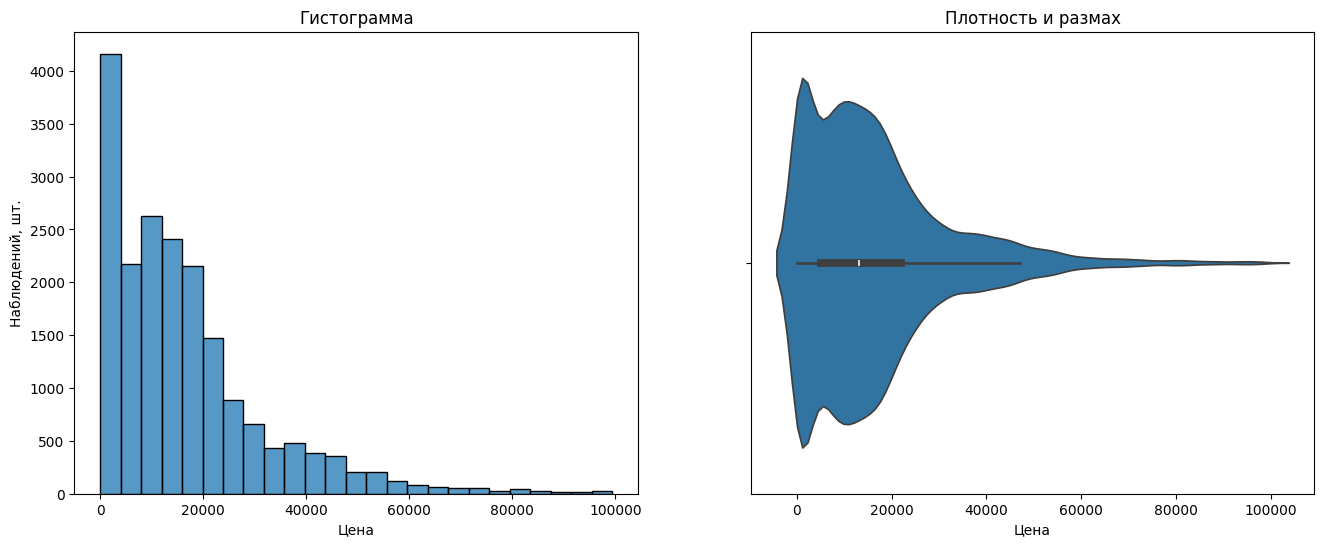

In [11]:
eda_visualize(df["Price"]);

In [12]:
(
    len(df[df.Price <= 1000]),
    len(df[(df.Price > 1000) & (df.Price <= 2000)]),
    len(df[(df.Price > 2000) & (df.Price <= 3000)]),
    len(df[(df.Price > 3000) & (df.Price <= 4000)]),
    len(df[(df.Price > 4000) & (df.Price <= 5000)]),
    len(df[(df.Price > 5000) & (df.Price <= 6000)]),
    len(df[(df.Price > 6000) & (df.Price <= 7000)]),
    len(df[(df.Price > 7000) & (df.Price <= 8000)]),
    len(df[(df.Price > 8000) & (df.Price <= 9000)]),
    len(df[(df.Price > 10000) & (df.Price <= 11000)]),
)

(2585, 627, 436, 526, 452, 544, 540, 692, 569, 791)

Значения меньше 1000 являются выбросом с количественной точки зрения.
Может создать отдельную модель для значений меньше 1000?
Посмотрим эту тысячу по сотням.

In [13]:
(
    len(df[df.Price <= 100]),
    len(df[(df.Price > 100) & (df.Price <= 200)]),
    len(df[(df.Price > 200) & (df.Price <= 300)]),
    len(df[(df.Price > 300) & (df.Price <= 400)]),
    len(df[(df.Price > 400) & (df.Price <= 500)]),
    len(df[(df.Price > 500) & (df.Price <= 600)]),
    len(df[(df.Price > 600) & (df.Price <= 700)]),
    len(df[(df.Price > 700) & (df.Price <= 800)]),
    len(df[(df.Price > 800) & (df.Price <= 900)]),
    len(df[(df.Price > 1000) & (df.Price <= 1100)]),
)

(381, 279, 240, 487, 278, 185, 196, 278, 122, 125)

In [14]:
#Аналогично отбросим все ниже 1000
df = df[(df.Price >= 1000)]

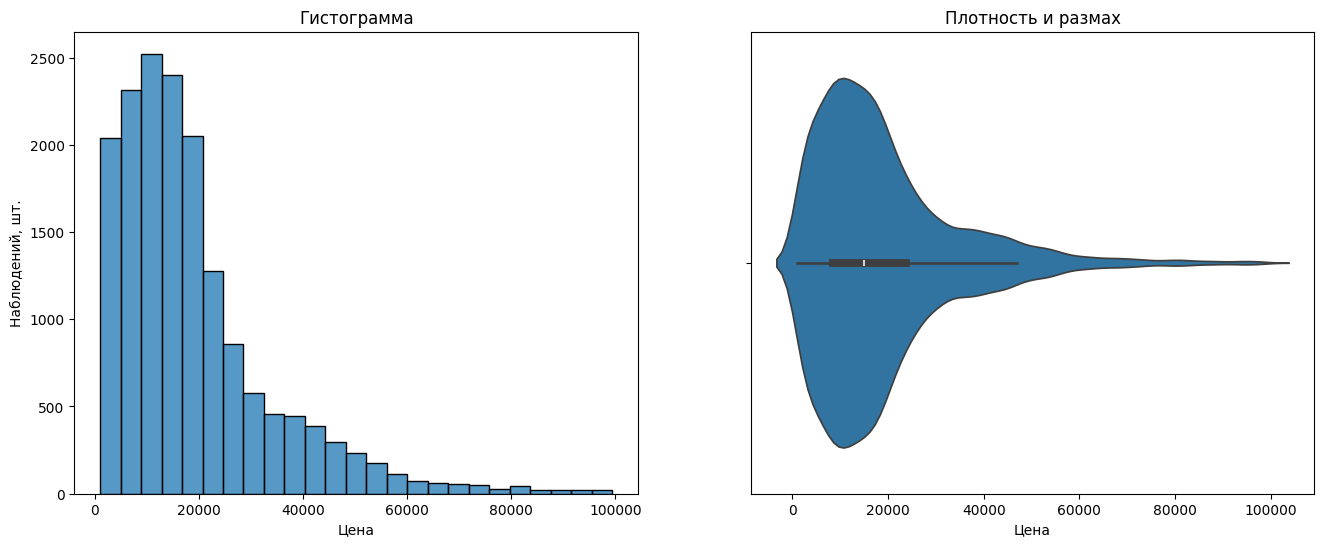

In [15]:
eda_visualize(df["Price"])

- Levy: численный, дискретный, слабая корреляция c Price 0.14, группировка ничего не дала.

Levy перевод - сбор. Похоже на какой-то налог.

По информации с kaggle: "Tax of importing and exporting the cars."
Учитывая что всего 9 уникальных значений, то это дискретная величина.
Так же указано, что не определена валюта и смысл для "-".

Принял "-", как 0 и изменил тип колонки на числовой.

In [16]:
df["Levy"] = df["Levy"].replace("-", 0)
df = df.astype({"Levy": "int32"})

In [17]:
df["Levy"].value_counts().sort_values(ascending=False)

Levy
0       5383
765      460
891      439
639      382
640      356
        ... 
1836       1
328        1
4860       1
3811       1
1045       1
Name: count, Length: 537, dtype: int64

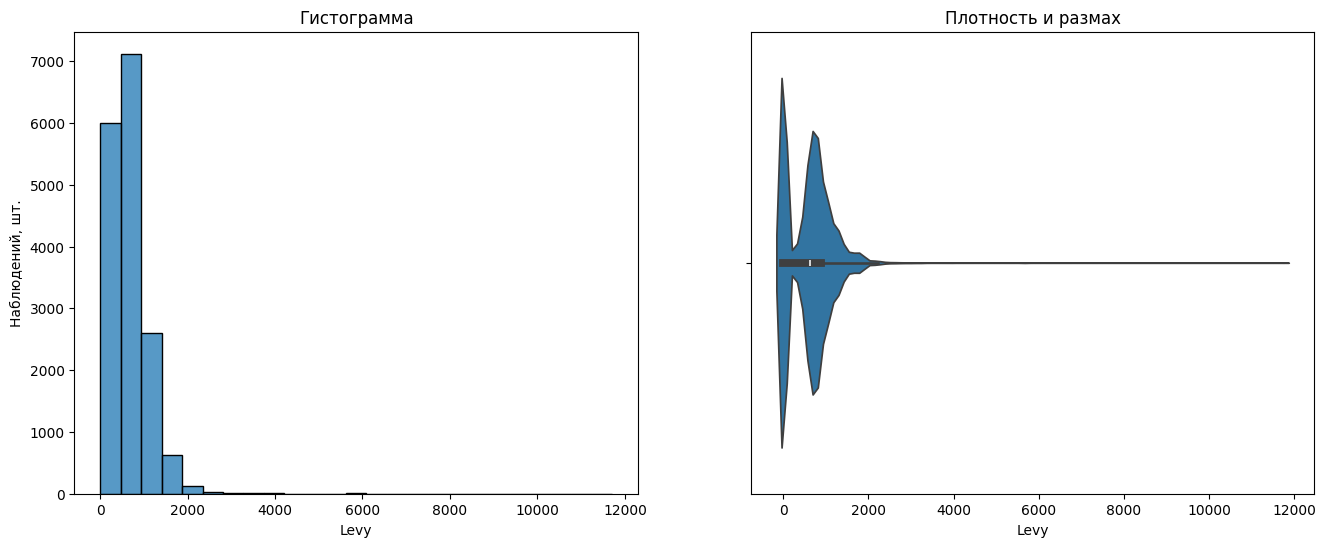

In [18]:
eda_visualize(df["Levy"])

In [19]:
df["Levy"].quantile(0.995)

2343.8850000000275

In [20]:
df["Levy"].quantile(0.005)

0.0

In [21]:
df["Levy"].mean()

599.0987915407856

In [22]:
df["Levy"].median()

640.0

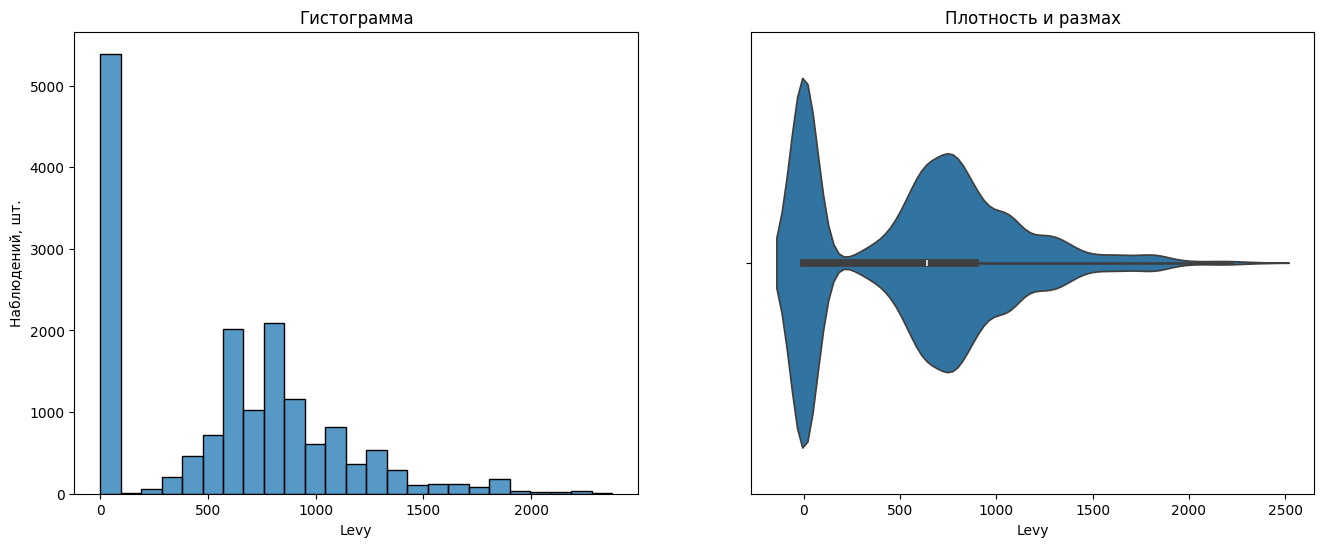

In [23]:
df = df[df["Levy"] < 2400]
eda_visualize(df["Levy"])

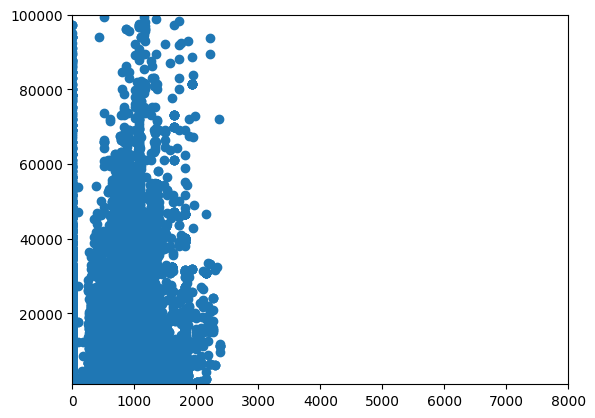

In [24]:
plt.scatter(df['Levy'], df['Price'])
plt.xlim(0, 8_000)
plt.ylim(1000, 100_000);

In [25]:
l_levy = LinearRegression()
l_levy.fit(df[['Levy']], df['Price'])

LinearRegression()

In [26]:
levy_prediction = l_levy.predict(df[['Levy']])

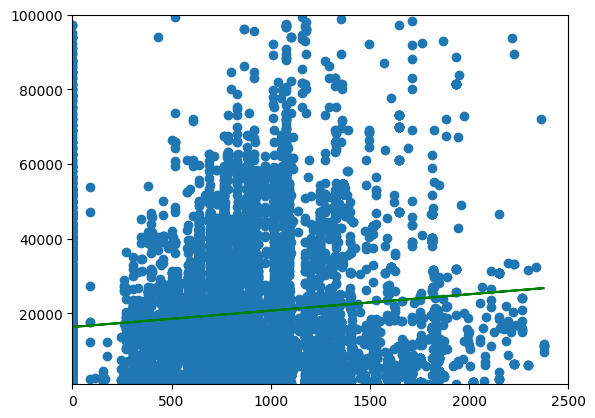

In [27]:
plt.scatter(df['Levy'], df['Price'])
plt.xlim(0, 2_500)
plt.ylim(1000, 100_000)
plt.plot(df['Levy'], levy_prediction, c='green');

/tmp/ipykernel_19974/3823295761.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(grouped_levy)["Price"].agg("mean").plot(kind="bar");


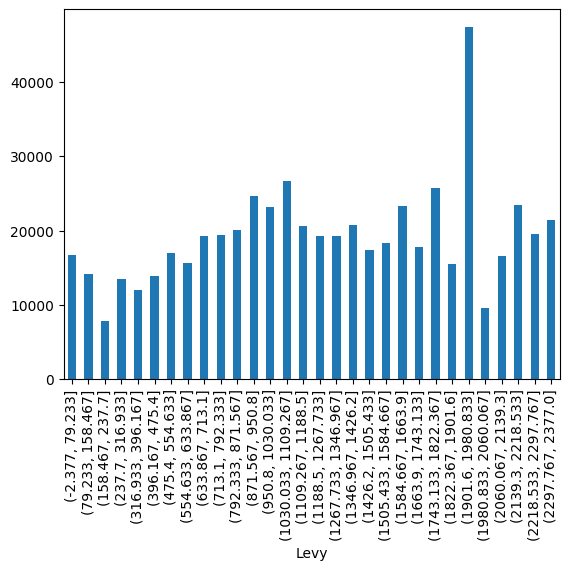

In [28]:
grouped_levy: pd.Series = pd.cut(df["Levy"], 30)
df.groupby(grouped_levy)["Price"].agg("mean").plot(kind="bar");

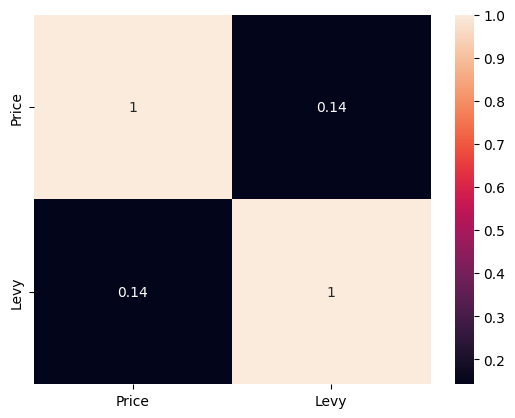

In [29]:
sns.heatmap(df[["Price", "Levy"]].corr(), annot=True);

- Manufacturer:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

In [30]:
df.loc[df["Manufacturer"] == "სხვა", "Manufacturer"] = df["Model"].apply(lambda x: x.split(" ")[0])

,mean,median,count
Manufacturer,,,
ACURA,8710.500000,4626.0,10
ALFA ROMEO,9890.250000,8522.0,4
ASTON MARTIN,54000.000000,54000.0,1
AUDI,17314.906736,11760.0,193
BMW,21409.234716,15681.0,916
...,...,...,...
UAZ,5290.750000,5331.0,12
VAZ,4694.723404,3607.0,47
VOLKSWAGEN,12591.407129,12544.0,533


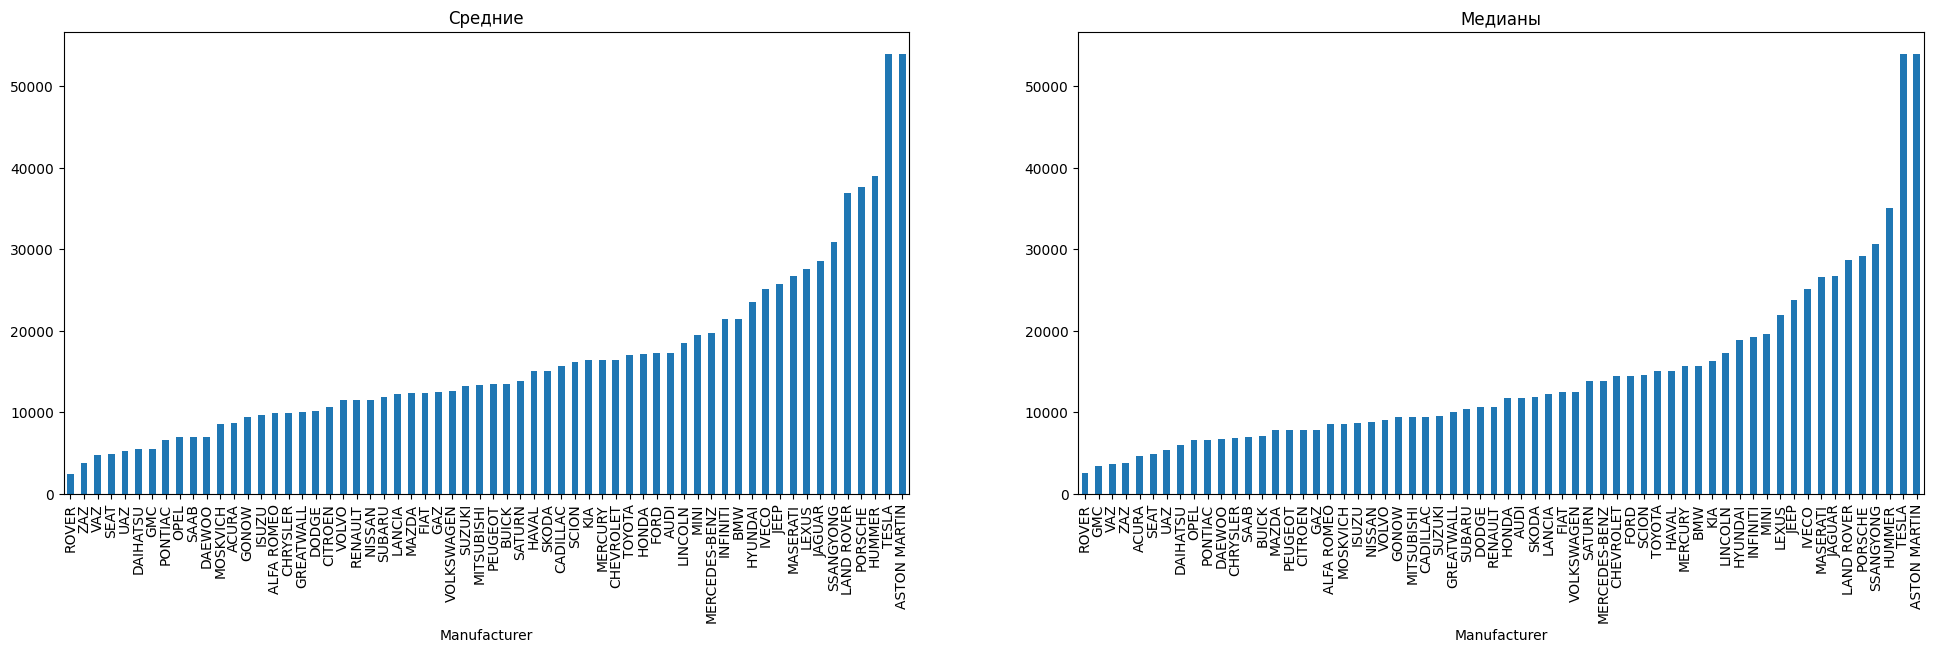

In [31]:
price_by_category(df, "Manufacturer", figsize=(24,6))

- Model (не знаю как оценить наличие зависимости, очень много категорий относительно размера выборки 1.5к/16.5к, хороший кандидат для удаления)

- Prod. year: численный, дискретный, средняя корреляция с Price 0.41

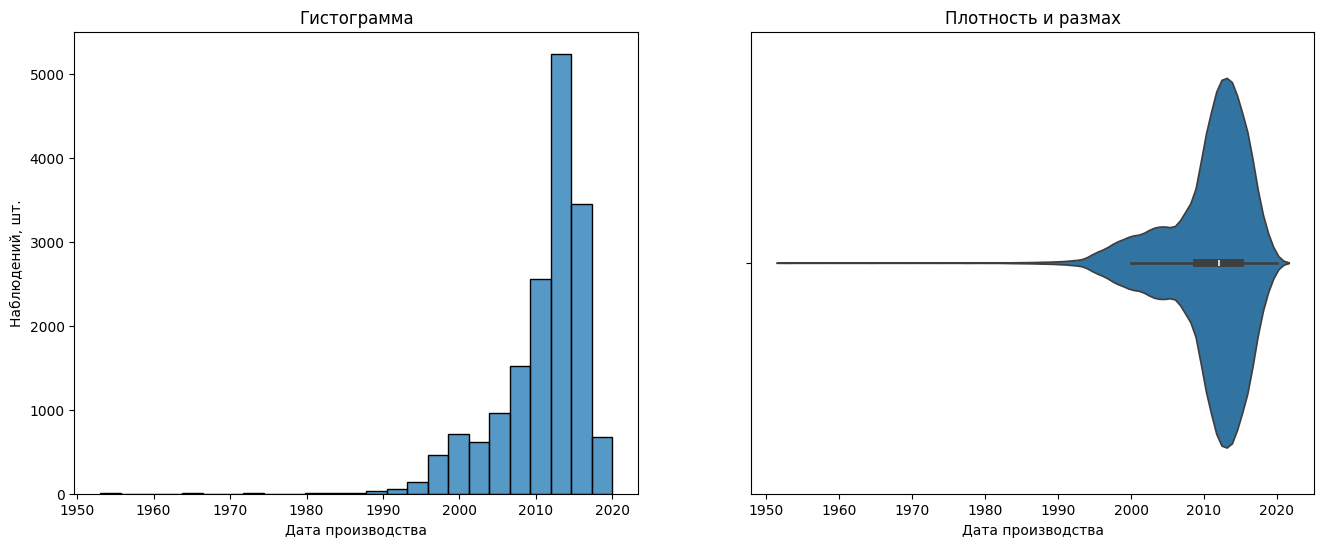

In [32]:
eda_visualize(df["Prod. year"])

In [33]:
df = df[df["Prod. year"] >= 1990]

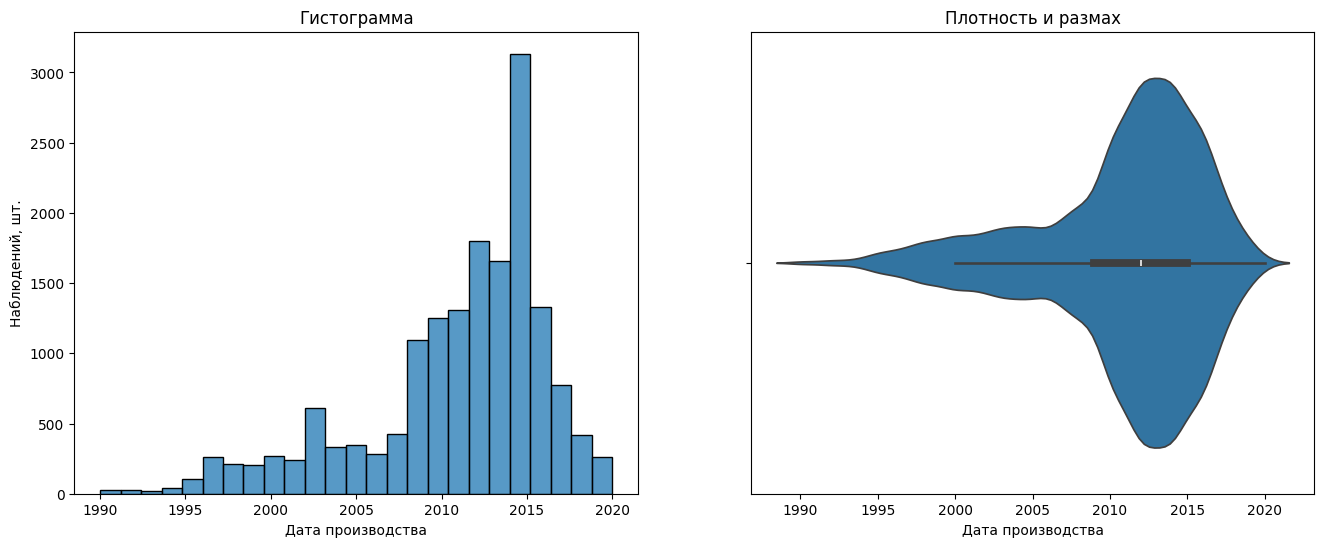

In [34]:
eda_visualize(df["Prod. year"])

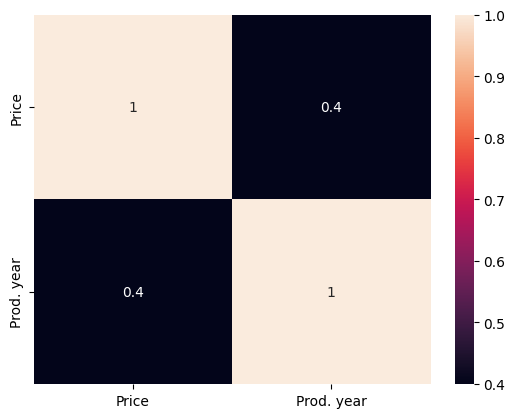

In [35]:
sns.heatmap(df[["Price", "Prod. year"]].corr(), annot=True);

- Category:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Category,,,
Cabriolet,25156.967742,20071.0,31
Coupe,19273.257322,15290.5,478
Goods wagon,9860.217778,8781.0,225
Hatchback,13377.291822,11917.0,2409
Jeep,26376.337628,22841.5,4502
Limousine,23677.500000,27441.0,4
Microbus,19509.110345,16308.0,290
Minivan,21270.964228,18654.0,615
Pickup,28704.279070,22580.0,43


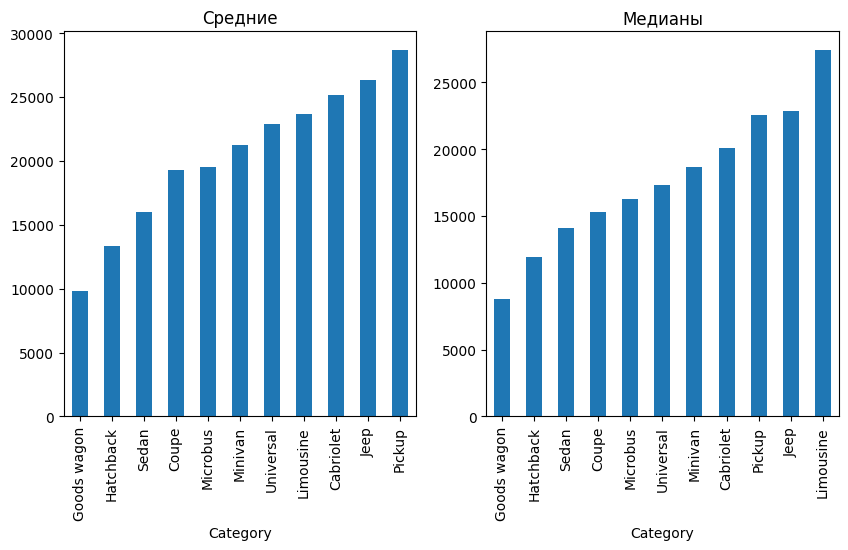

In [36]:
price_by_category(df, "Category", figsize=(10, 5))

- Leather interior: логический, среднее при наличии возрастает, что говорит о связи

In [37]:
df["Leather interior"] = pd.get_dummies(df["Leather interior"], drop_first=True)

,mean,median,count
Leather interior,,,
False,14023.268095,12231.0,4946
True,21073.646382,16944.5,11470


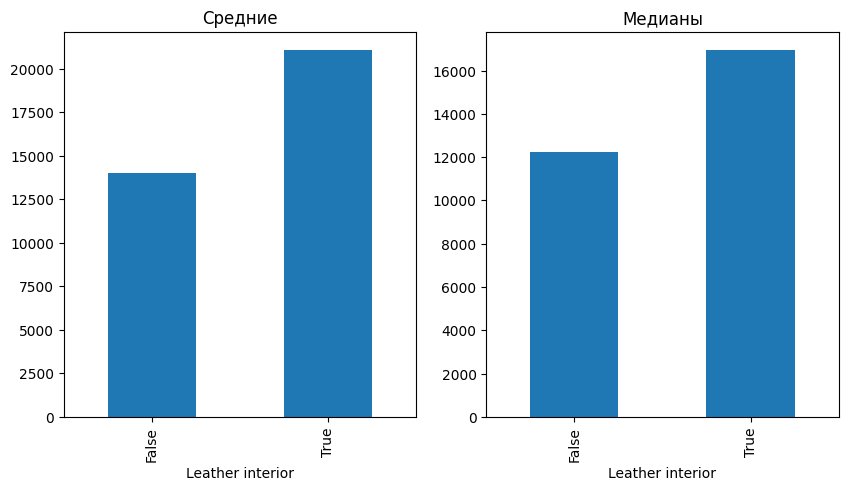

In [38]:
price_by_category(df, "Leather interior", figsize=(10, 5))

- Fuel type:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Fuel type,,,
CNG,8672.554622,7527.0,476
Diesel,25100.588694,21953.0,3715
Hybrid,14389.396284,13291.0,2637
Hydrogen,20385.000000,20385.0,1
LPG,13595.781358,11604.0,869
Petrol,18753.335148,15053.0,8632
Plug-in Hybrid,23700.453488,22737.0,86


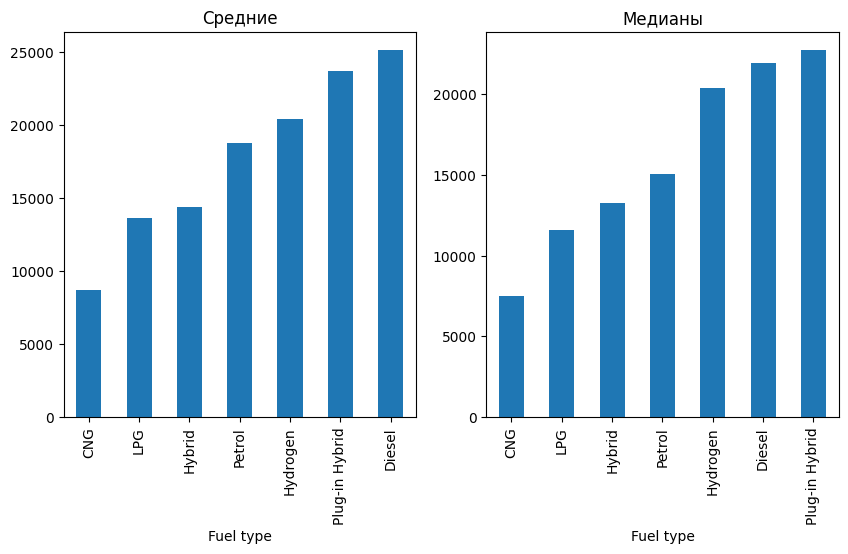

In [39]:
price_by_category(df, "Fuel type", figsize=(10, 5))

- Engine volume: численный, дискретный, стоит попробовать сгруппировать

In [40]:
def has_turbo(x: str) -> bool:
    return "Turbo" in x
df["Turbo"] = df["Engine volume"].apply(has_turbo)

In [41]:
def engine_volume_to_float(x: str) -> float:
    return float(x.replace(" Turbo", ""))
df["Engine volume"] = df["Engine volume"].apply(engine_volume_to_float)

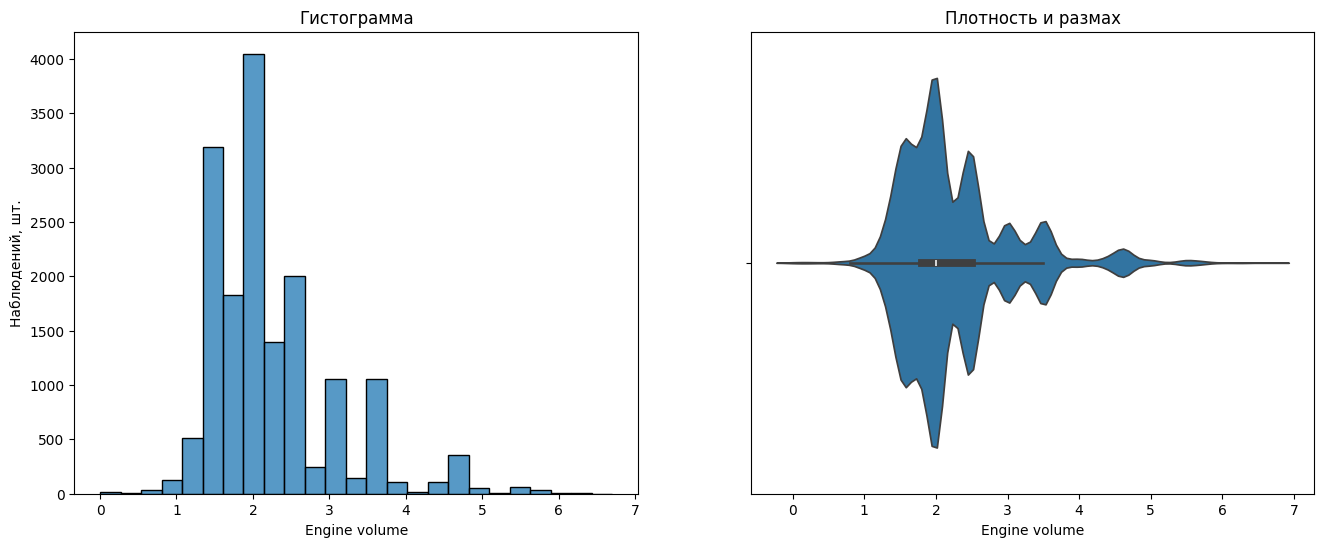

In [42]:
eda_visualize(df["Engine volume"])

- Turbo: логический, среднее при наличии возрастает, что говорит о связи

,mean,median,count
Turbo,,,
False,18199.495749,14454.0,14586
True,24926.755738,19444.0,1830


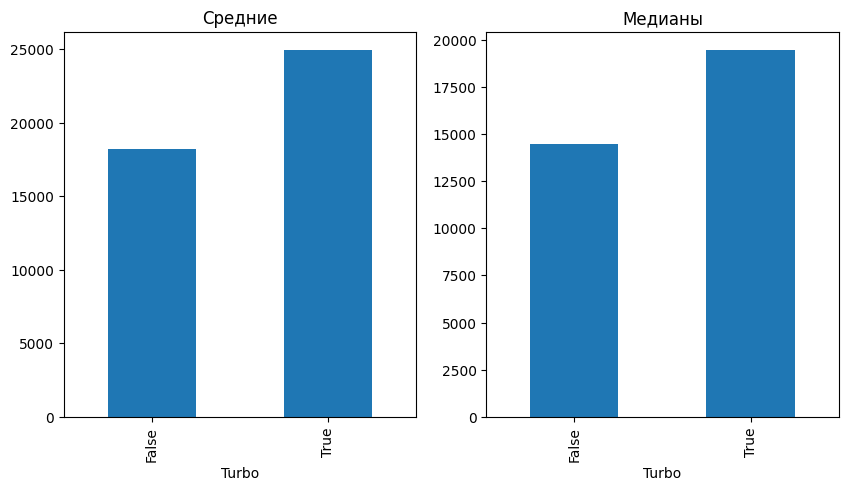

In [43]:
price_by_category(df, "Turbo", figsize=(10, 5))

- Mileage: численный, непрерывный, слабая корреляция с Price -0.21
- Mileage km/h: численный, непрерывный, слабая корреляция с Price -0.13

In [44]:
def mileage_to_int(x: str) -> int:
    return int(x.replace(" km", ""))
df["Mileage"] = df["Mileage"].apply(mileage_to_int)

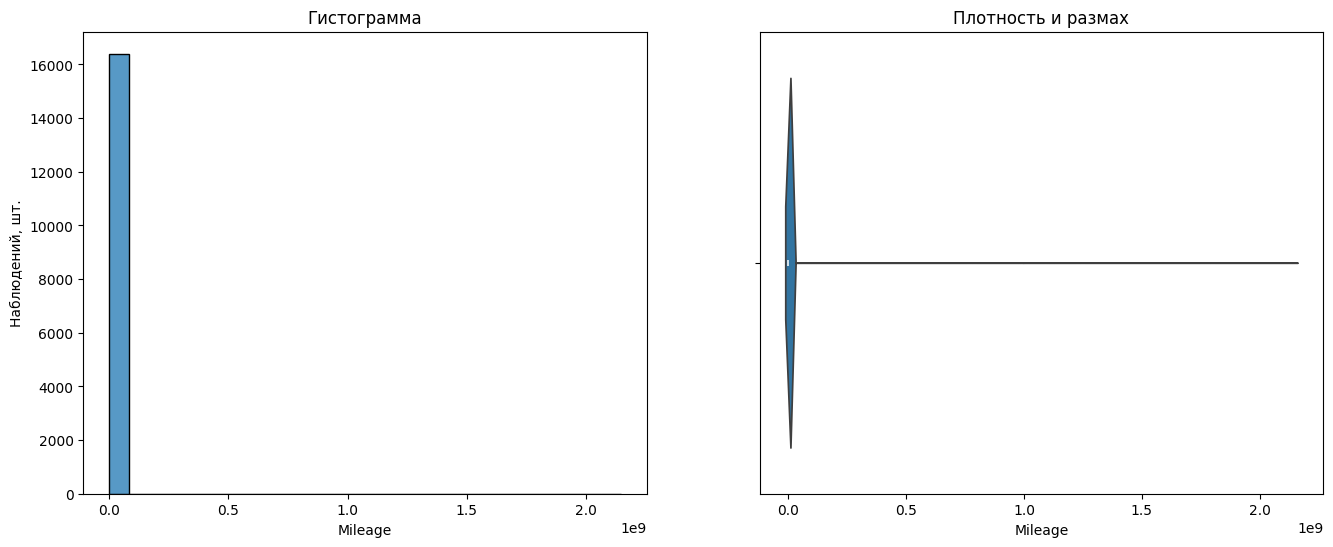

In [45]:
eda_visualize(df["Mileage"])

In [46]:
df["Mileage km/h"] = df["Mileage"]/((2023 - df["Prod. year"]) * 365 * 12)

In [47]:
df["Mileage km/h"].quantile(0.975)

9.573896952235993

In [48]:
df["Mileage km/h"].quantile(0.025)

0.0

In [49]:
df = df[df["Mileage km/h"] <= 10]

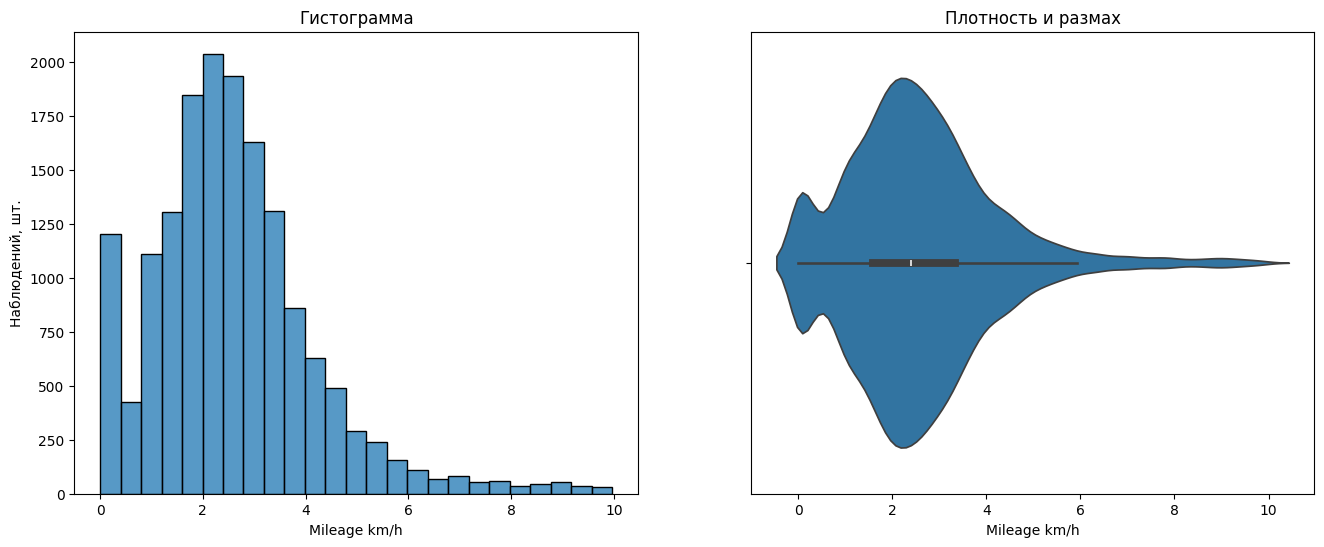

In [50]:
eda_visualize(df["Mileage km/h"])

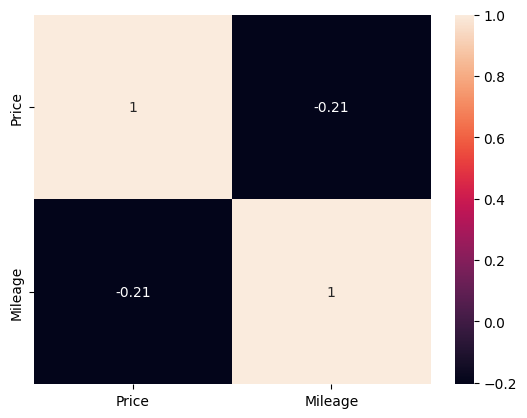

In [51]:
sns.heatmap(df[["Price", "Mileage"]].corr(), annot=True);

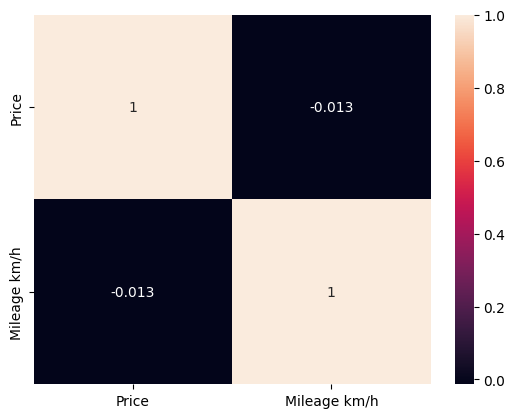

In [52]:
sns.heatmap(df[["Price", "Mileage km/h"]].corr(), annot=True);

- Cylinders: численный, дискретный, стоит попробовать сгруппировать

In [53]:
df = df.astype({"Cylinders": "int32"})

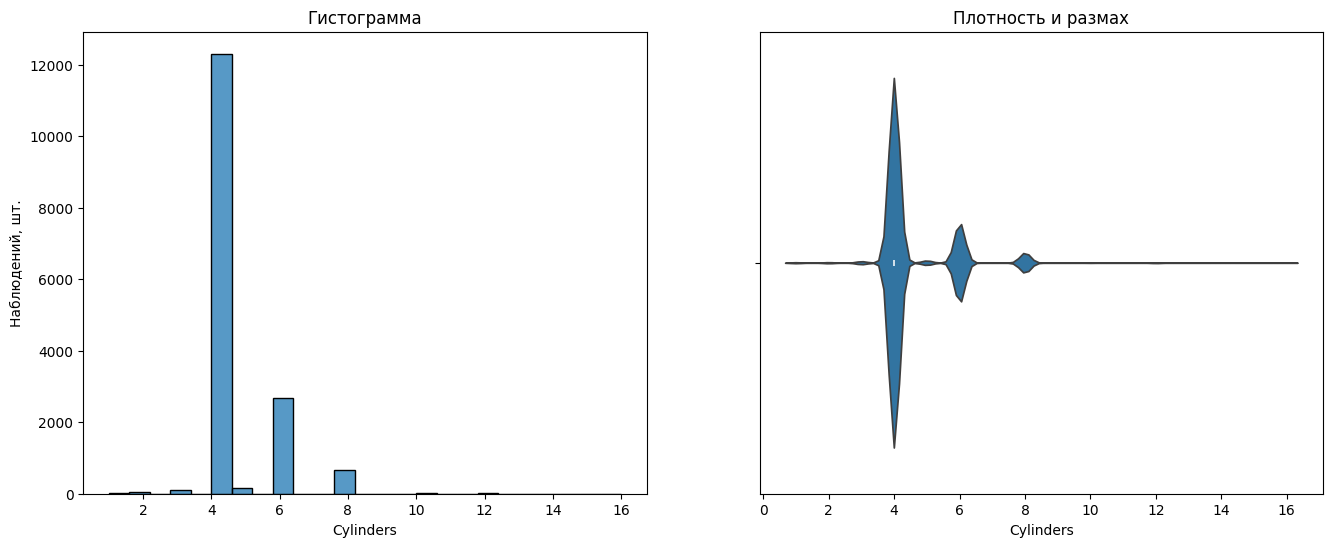

In [54]:
eda_visualize(df["Cylinders"])

- Wheel: логический, среднее при наличии возрастает, что говорит о связи

In [55]:
df["Right_hand"] = pd.get_dummies(df["Wheel"], drop_first=True)

,mean,median,count
Right_hand,,,
False,19970.107363,16308.0,14735
True,9776.177556,8938.0,1301


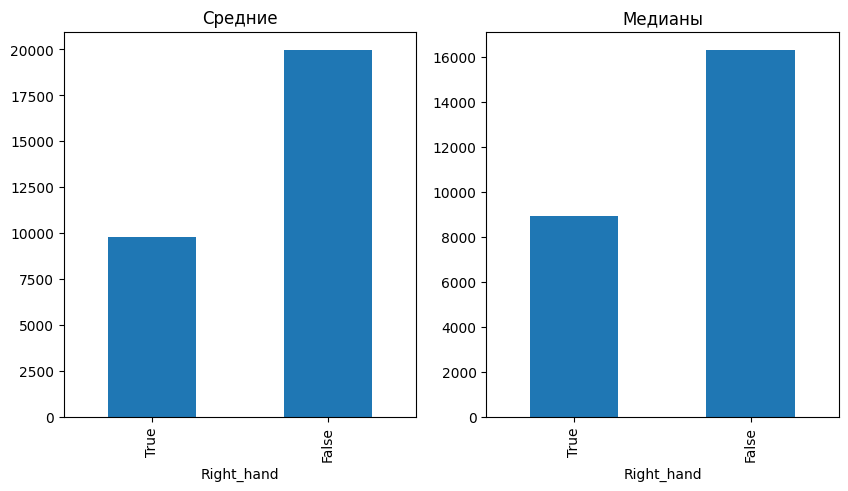

In [56]:
price_by_category(df, "Right_hand", figsize=(10, 5))

- Gear box type:
    категориальный с малым кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Gear box type,,,
Automatic,19161.175738,15624.0,10675
Manual,11909.499711,9095.0,1731
Tiptronic,24245.157030,18817.0,2923
Variator,15486.350778,13799.0,707


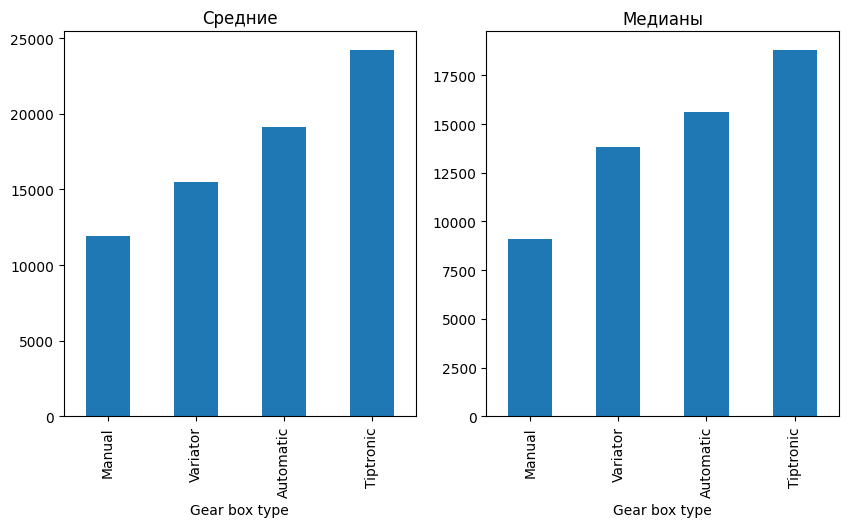

In [57]:
price_by_category(df, "Gear box type", figsize=(10, 5))

- Drive wheels:
    категориальный с малым кол-вом категорий
    среднее по категории возрастает, но слабо, вряд ли имеет значимую связь

,mean,median,count
Drive wheels,,,
4x4,21994.875576,15681.0,3038
Front,18564.688162,15681.0,11041
Rear,17979.144098,12858.0,1957


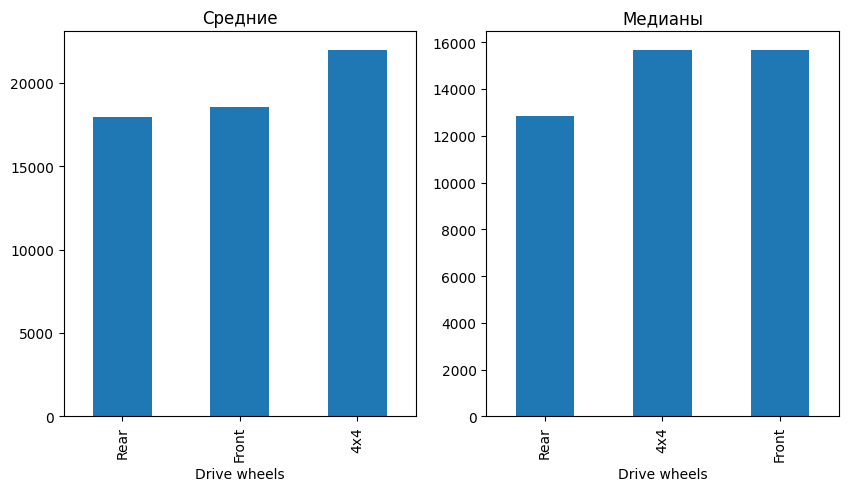

In [58]:
price_by_category(df, "Drive wheels", figsize=(10, 5))

- Doors:
    категориальный с малым кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи

,mean,median,count
Doors,,,
02-Mar,15275.105413,10976.0,702
04-May,19293.115301,15681.0,15221
>5,22962.008850,17249.0,113


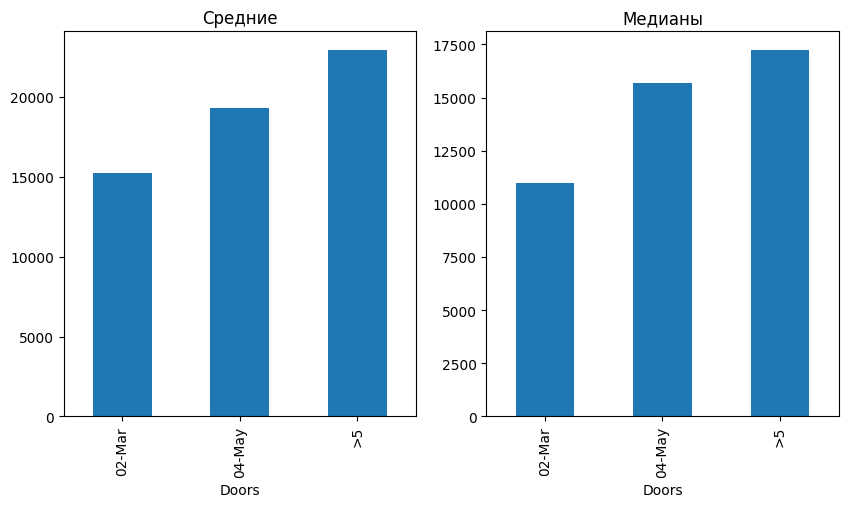

In [59]:
price_by_category(df, "Doors", figsize=(10, 5))

- Color:
    категориальный с большим кол-вом категорий
    среднее по категории возрастает, что говорит о наличии связи, стоит попробовать без.

,mean,median,count
Color,,,
Beige,16784.825000,13328.5,120
Black,20853.515640,16621.0,4092
Blue,16575.380480,11917.0,1209
Brown,22541.160256,17249.0,156
Carnelian red,16074.446429,15053.0,168
Golden,15014.935252,12858.0,139
Green,10077.579137,7370.0,278
Grey,21924.543851,18189.0,1984
Orange,18302.196721,16960.0,61


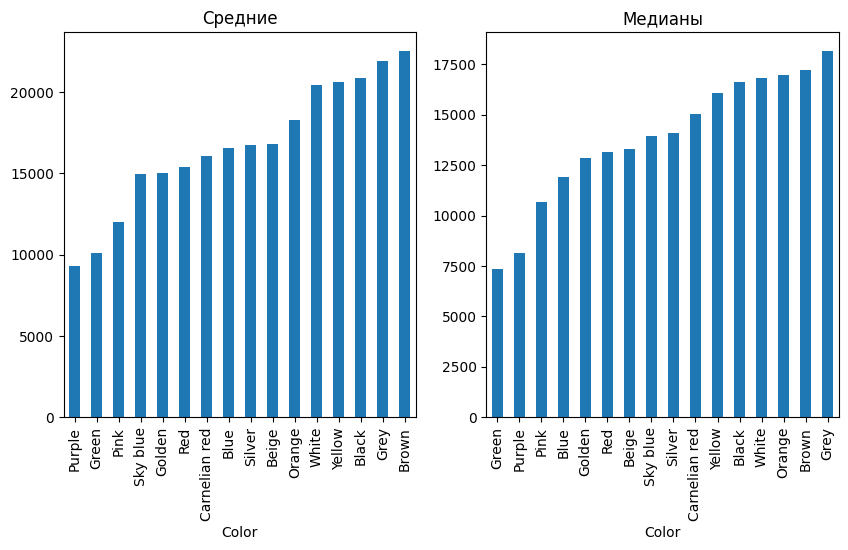

In [60]:
price_by_category(df, "Color", figsize=(10, 5))

- Airbags: численный, дискретный, стоит попробовать сгруппировать

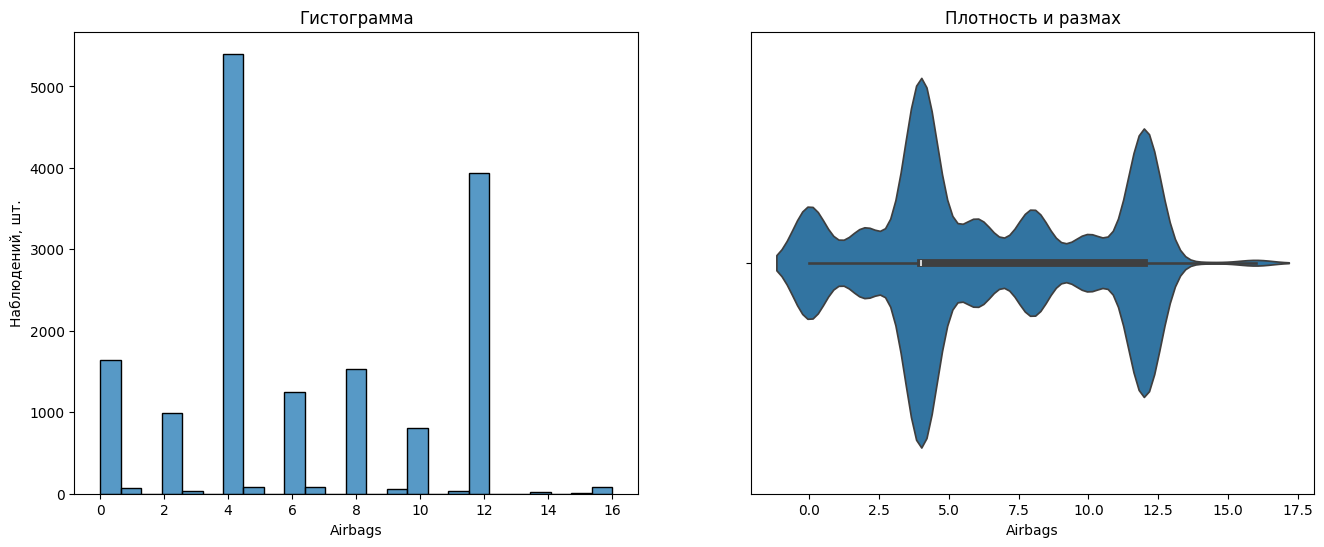

In [61]:
eda_visualize(df["Airbags"])

In [62]:
df = pd.concat([
    df,
    pd.get_dummies(df["Doors"], drop_first=True),
    pd.get_dummies(df["Drive wheels"], drop_first=True),
    pd.get_dummies(df["Gear box type"], drop_first=True),
], axis=1)
df = df.rename(columns={"04-May": "4 doors", ">5": ">5 doors"})

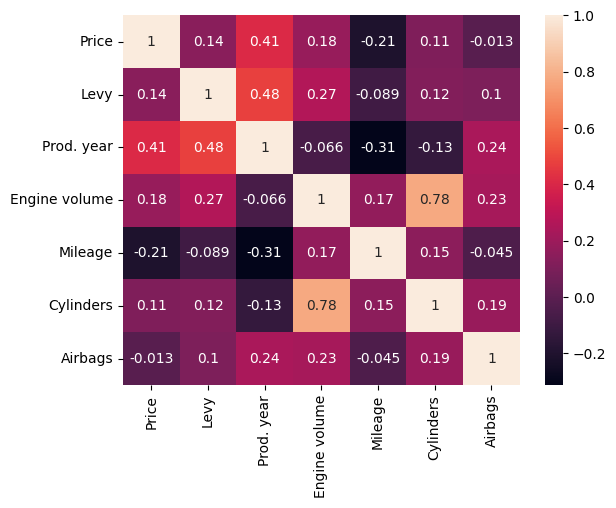

In [63]:
sns.heatmap(df[["Price", "Levy", "Prod. year", "Engine volume", "Mileage", "Cylinders", "Airbags"]].corr(), annot=True);

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16036 entries, 0 to 19235
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                16036 non-null  int64  
 1   Price             16036 non-null  int64  
 2   Levy              16036 non-null  int32  
 3   Manufacturer      16036 non-null  object 
 4   Model             16036 non-null  object 
 5   Prod. year        16036 non-null  int64  
 6   Category          16036 non-null  object 
 7   Leather interior  16036 non-null  bool   
 8   Fuel type         16036 non-null  object 
 9   Engine volume     16036 non-null  float64
 10  Mileage           16036 non-null  int64  
 11  Cylinders         16036 non-null  int32  
 12  Gear box type     16036 non-null  object 
 13  Drive wheels      16036 non-null  object 
 14  Doors             16036 non-null  object 
 15  Wheel             16036 non-null  object 
 16  Color             16036 non-null  object 
 17

In [67]:
def predict_and_measure(model=None, drop_columns=None):
    if drop_columns is None:
        drop_columns = ["Price", "ID"]
    else:
        drop_columns = ["Price", "ID"] + drop_columns
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(drop_columns, axis=1),
        df["Price"],
        test_size=0.2,
        random_state=144,
        shuffle=True,
    )
    if "Model" not in drop_columns:
        encoder_mo = LeaveOneOutEncoder()
        X_train["Model"] = encoder_mo.fit_transform(X_train["Model"], y_train)
    if "Manufacturer" not in drop_columns:
        encoder_ma = LeaveOneOutEncoder()
        X_train['Manufacturer'] = encoder_ma.fit_transform(X_train['Manufacturer'], y_train)
    if "Color" not in drop_columns:
        encoder_col = LeaveOneOutEncoder()
        X_train['Color'] = encoder_col.fit_transform(X_train['Color'], y_train)
    if "Fuel type" not in drop_columns:
        encoder_ft = LeaveOneOutEncoder()
        X_train['Fuel type'] = encoder_ft.fit_transform(X_train['Fuel type'], y_train)
    if "Category" not in drop_columns:
        encoder_cat = LeaveOneOutEncoder()
        X_train['Category'] = encoder_cat.fit_transform(X_train['Category'], y_train)

    if model is None:
        model = LinearRegression()

    pipeline = Pipeline([
        ('scaler', StandardScaler()), # масштабирование
        ('model', model),
    ])
    pipeline.fit(X_train, y_train)

    if "Model" not in drop_columns:
        X_test["Model"] = encoder_mo.transform(X_test["Model"], y_test)
    if "Manufacturer" not in drop_columns:
        X_test['Manufacturer'] = encoder_ma.transform(X_test['Manufacturer'], y_test)
    if "Color" not in drop_columns:
        X_test['Color'] = encoder_col.transform(X_test['Color'], y_test)
    if "Fuel type" not in drop_columns:
        X_test['Fuel type'] = encoder_ft.fit_transform(X_test['Fuel type'], y_test)
    if "Category" not in drop_columns:
        X_test['Category'] = encoder_cat.fit_transform(X_test['Category'], y_test)

    prediction = pipeline.predict(X_test)

    return (
        mean_squared_error(y_test, prediction),
        mean_absolute_error(y_test, prediction),
        r2_score(y_test, prediction),
    )


In [68]:
predict_and_measure(drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel"])

(129451504.1749887, 7971.370145017226, 0.4598717657238742)

46% r_score на всех столбцах, после более качественной работы над выбросами
Попробуем без модели

In [69]:
predict_and_measure(drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel", "Model"])

(139752364.34747642, 8422.218828028697, 0.41689207651941285)

4.5% от признака модели

In [70]:
predict_and_measure(drop_columns=["Doors", "Drive wheels", "Gear box type", "Wheel", "4 doors", ">5 doors", "Front", "Rear"])

(129928587.2724097, 7997.233515286344, 0.45788116659831557)

Тип дверей и привода на многое не влияют.
Попробуем убирать признаки без потери r_score.

In [71]:
predict_and_measure(
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)

(130267416.79538831, 8021.415594095734, 0.45646742178991484)

Следующим шагом попробую использовать TweedieRegressor.

In [72]:
predict_and_measure(
    model=TweedieRegressor(max_iter=1000),
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)

(152001049.65216187, 8394.56457691467, 0.36578520983611373)

In [73]:
predict_and_measure(
    model=TweedieRegressor(power=1, max_iter=1000),
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)

(110526915.29991774, 7008.860359120388, 0.5388334188822361)

In [74]:
predict_and_measure(
    model=TweedieRegressor(power=2, max_iter=1000),
    drop_columns=[
        "Doors",
        "Drive wheels",
        "Gear box type",
        "Wheel",
        "4 doors",
        ">5 doors",
        "Front",
        "Rear",
        "Leather interior",
        "Cylinders",
        "Mileage",
        "Right_hand",
    ],
)

(149490638.78403577, 8110.685326143313, 0.37625974080545355)

r2_score при power = 1 54%